In [2]:
! pip install plotly

  Running setup.py bdist_wheel for retrying: started
  Running setup.py bdist_wheel for retrying: finished with status 'done'
  Stored in directory: C:\Users\Saurabh\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


# Advanced section 3 - Regularization

This notebooks shows, in code, the effects of the regularization methods. We also show the instability that can arise in OLS.

In [3]:
# Imports
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as a3d

# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.plotly import plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from copy import deepcopy

%matplotlib inline
%matplotlib notebook

NameError: name 'init_notebook_mode' is not defined

## Create regression problem

To exemplify the estimators and their behavior on different types of data, we create a basic 2D regression, as well as a 2d regression with highly colinear predictors. Let's start with a normal regression with random predictor values:

In [51]:
## Global variables for plots

# True betas:
b_true = np.array([3,7]).reshape((2,1))

# Samples and Y noise
N=300
sigma = 5

# linspaces
lsp = np.linspace(-1.5,1.5,20)
lsp_x, lsp_y = np.meshgrid(lsp,lsp)
lsp_mat = np.column_stack((lsp_x.flatten(),lsp_y.flatten()))


In [52]:
# Generate random data from the true betas
X = np.random.rand(N,2)*10-5
X = (X - X.mean(axis=0))/X.std(axis=0)
eps = np.random.normal(scale=sigma, size = (N,1))
y = np.dot(X,b_true) + eps


## Plot regression problem

<IPython.core.display.Javascript object>


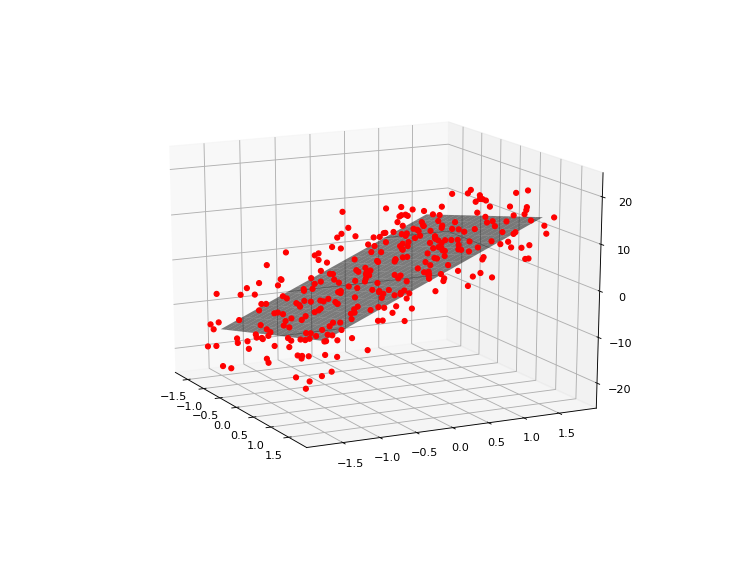

In [53]:
# 3D plot with Axes3D. 3D plotting with this is suboptimal, as it does no actual 3d rendering.

def plot_scatter_axes3d(X,y,b_true):
    # y surface from true betas
    y_noiseless = np.dot(lsp_mat,b_true).reshape((20,20))
    fig = plt.figure(figsize=[9,7])
    ax = fig.gca(projection='3d')
    ax.scatter(X[:,0],X[:,1], y, color='red', alpha =1, zorder=y)
    ax.plot_surface(lsp_x, lsp_y, np.dot(lsp_mat,b_true).reshape((20,20)), color='black', alpha = 0.5, zorder = y_noiseless)
    plt.show()
    
plot_scatter_axes3d(X,y,b_true);

In [58]:
# 3D plot with plotly. Plotly is a much better approach for 3d plots, but it requires the user to have an online account.

# plotly.tools.set_credentials_file(username='camilofosco', api_key='AY1QtDdBCza2qZePnygz')

def plot_scatter_plotly(X,y,b_true):

    # y surface from true betas
    y_noiseless = np.dot(lsp_mat,b_true).reshape((20,20))
    
    data = [
        go.Scatter3d(
        x=X[:,0],
        y=X[:,1],
        z=y,
        mode='markers',
        marker=dict(
            size=5,
            color='green',
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
                ),
            opacity=1
            )
        ),
        go.Surface(
                x=lsp_x,
                y=lsp_y,
                z=y_noiseless,
                colorscale='Greens',
                opacity=0.8,
                showscale=False
        ),

 
    ]

    layout = go.Layout(
        title='2D Regression',
        autosize=False,
        width=700,
        height=700,
    )

    fig = go.Figure(data=data, layout=layout)
        
    return fig, data

print(X.shape, y.shape)

fig, data = plot_scatter_plotly(X,y,b_true)
print(len(data))
iplot(fig, filename='2D Regression - normal data')

(300, 2) (300, 1)
2


In [59]:
# Regression types to use:
regr = ['OLS']
colors = ['Blues', 'Reds']

## Calculate regression coefficients for OLS (normal data)

In [93]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV


def fit_regression(X, y, regr=['OLS'], verbose=True):
    betas=[]
    if regr == 'all':
        regr = ['OLS','Ridge','LASSO','EN']
        
    for r in regr:
        if r == 'OLS':
            # OLS fit
            regr_ols = LinearRegression(fit_intercept=False)
            regr_ols.fit(X, y)
            beta_ols = regr_ols.coef_ 
            if verbose:
                print(f'OLS coefficients: {beta_ols}')
            betas.append(beta_ols)
        
        elif r == 'Ridge':
            # Ridge fit
            regr_ridge = RidgeCV(fit_intercept=False)
            regr_ridge.fit(X, y)
            beta_ridge = regr_ridge.coef_
            if verbose:
                print(f'Ridge coefficients:{beta_ridge}, regularization coef: {regr_ridge.alpha_}')
            betas.append(beta_ridge)
        
        elif r == 'LASSO':
            # LASSO fit
            regr_lasso = LassoCV(fit_intercept=False)
            regr_lasso.fit(X, y)
            beta_lasso = regr_lasso.coef_ 
            if verbose:
                print(f'LASSO coefficients:{beta_lasso}, regularization coef: {regr_lasso.alpha_}')
            betas.append(beta_lasso)

        elif r == 'EN':
            # Elastic Net fit
            regr_EN = ElasticNetCV(fit_intercept=False)
            regr_EN.fit(X, y)
            beta_EN = regr_EN.coef_ 
            if verbose:
                print(f'ElasticNet coefficients:{beta_EN}, regularization coef: {regr_EN.alpha_}')
            betas.append(beta_EN)
    
    return betas

print('True coefficents:', b_true.ravel())
betas = fit_regression(X,y.ravel(),regr=regr);

True coefficents: [3 7]
OLS coefficients: [2.89216421 6.95112742]


## Plot fitted planes (normal data)

In [116]:
def plot_fitted_planes(betas, colors, names, data=[], return_traces=False):
    
    for i,b in enumerate(betas):
        y = np.dot(lsp_mat,b.reshape((2,1))).reshape((20,20))
        data.append(go.Surface(
                    x=lsp_x,
                    y=lsp_y,
                    z=y,
                    colorscale=colors[i],
                    text = names[i],
                    showscale=False
            ))

    layout = go.Layout(
        title='2D Regression',
        autosize=False,
        width=700,
        height=700,
    )
    
    if return_traces:
        return data
    
    fig = go.Figure(data=data, layout=layout)
    return fig
    
fig = plot_fitted_planes(betas, colors=colors, names=regr, data=deepcopy(data))
iplot(fig, filename='2D Regression with different estimators - normal data')

## Create regression problem with colinearity

In [117]:
# Generate random data with high colinearity between predictors
x1 = np.random.rand(N,1)*10-5
x2 = x1 + np.random.normal(scale=0.1, size=(N,1))
X_colin = np.column_stack((x1,x2))
X_colin = (X_colin-X_colin.mean(axis=0))/X_colin.std(axis=0)
eps = np.random.normal(scale=sigma, size = (N,1))
y_colin = np.dot(X_colin,b_true)+eps

## Plot regression problem with colinearity

In [118]:
fig, data_colin = plot_scatter_plotly(X_colin,y_colin,b_true)
iplot(fig, filename='2D Regression - normal data')

## Calculate regression coefficients (colinear data)

In [64]:
print('True coefficents:', b_true.ravel())
betas_colin = fit_regression(X_colin,y_colin.ravel(),regr=regr);

True coefficents: [3 7]
OLS coefficients: [9.28778571 0.30263443]


## Plot fitting planes (colinear data)

In [65]:
fig = plot_fitted_planes(betas_colin, colors=colors, names=regr, data=deepcopy(data_colin))
iplot(fig, filename='2D Regression with different estimators - colinear data')

## Add a small perturbation to the colinear data and fit again

In [71]:
# Perturbation is just a bit of small uniform noise:
perturbation = np.random.rand(X_colin.shape[0],X_colin.shape[1])*0.05
X_colin_pert = X_colin+perturbation
y_colin_pert = np.dot(X_colin_pert,b_true)+eps

print('True coefficents:', b_true.ravel())
betas = fit_regression(X_colin_pert,y_colin_pert.ravel(),regr=regr);
fig, data_colin_pert = plot_scatter_plotly(X_colin_pert,y_colin_pert,b_true)
fig = plot_fitted_planes(betas, colors=colors, names=regr, data=deepcopy(data_colin_pert))

iplot(fig, filename='2D Regression with different estimators - colinear data')

True coefficents: [3 7]
OLS coefficients: [0.3480226  9.24496111]


This clearly shows how unstable our estimates are in OLS. As expected, in this case, the inverse Gram Matrix $(X^TX)^{-1}$ (proportional to covariance) will present very large diagonal values:

In [68]:
print('Inverse of Gram Matrix for colinear data (propto covariance matrix of betas):')
print(np.linalg.inv(np.dot(X_colin.T,X_colin)))

print('Condition number of Gram Matrix:')
print(np.linalg.cond(np.dot(X_colin.T,X_colin)))

print('\nCompare to non-colinear data:')
print(np.linalg.inv(np.dot(X.T,X)))

print('Condition number of Gram Matrix with non-colinear data:')
print(np.linalg.cond(np.dot(X.T,X)))

Inverse of Gram Matrix for colinear data (propto covariance matrix of betas):
[[ 2.87349732 -2.87183017]
 [-2.87183017  2.87349732]]
Condition number of Gram Matrix:
3446.196493910531

Compare to non-colinear data:
[[3.33386079e-03 4.19339416e-05]
 [4.19339416e-05 3.33386079e-03]]
Condition number of Gram Matrix with non-colinear data:
1.0254768368917215


## Analyze loss surfaces

In [81]:

def OLS_loss(X, y, beta, lbda=0):
    y_hat = np.dot(X,beta)
    return np.sum((y_hat-y)**2,axis=0)

def Ridge_loss(X, y, beta, lbda):
    y_hat = np.dot(X,beta)
    return np.sum((y_hat-y)**2,axis=0) + lbda*np.sum(beta**2, axis=0)

def LASSO_loss(X, y, beta, lbda):
    y_hat = np.dot(X,beta)
    return (1 / (2 * len(X)))*np.sum((y_hat-y)**2,axis=0) + lbda*np.sum(np.abs(beta), axis=0)

def EN_loss(X, y, beta, lbda):
    ratio=0.1
    y_hat = np.dot(X,beta)
    return (1 / (2 * len(X)))*np.sum((y_hat-y)**2,axis=0) + lbda*(ratio*np.sum(beta**2, axis=0) + (1-ratio)*np.sum(np.abs(beta), axis=0))


In [91]:
# linspace for loss surface
L=40
lsp_b = np.linspace(-20,20,L)
lsp_b_x, lsp_b_y = np.meshgrid(lsp_b,lsp_b)
lsp_b_mat = np.column_stack((lsp_b_x.flatten(),lsp_b_y.flatten()))

def build_surface_fig(loss_values):
    
    data = [
        go.Surface(
                x=lsp_b_x,
                y=lsp_b_y,
                z=loss_values,
                colorscale='Viridis',
                    opacity=0.7,
                    contours=dict(z=dict(show=True,
                                         width=3,
                                         highlight=True,
                                         highlightcolor='orange',
                                         project=dict(z=True),
                                         usecolormap=True))
        )
    ]

    layout = go.Layout(
        title='Loss surface',
        autosize=False,
        width=700,
        height=700,
        scene=dict(
        xaxis = dict(
            title='Beta 1'),
        yaxis = dict(
            title='Beta 2'),
        zaxis = dict(
            title='Loss')
        )
    )

    fig = go.Figure(data=data, layout=layout)
    display(iplot(fig, filename='2D Regression with different estimators - colinear data'))

build_surface_fig(OLS_loss(X_colin,y_colin.reshape(-1,1), lsp_b_mat.T, 100).reshape((L,L)));

In [75]:
# # OLS
# loss_values = OLS_loss(X, y, lsp_b_mat.T).reshape((L,L))
# fig, data = build_surface_fig(loss_values)
# iplot(fig, filename='Loss Surface')

# # Ridge
# loss_values = Ridge_loss(X, y, lsp_b_mat.T, 100.0).reshape((L,L))
# fig, data = build_surface_fig(loss_values)
# iplot(fig, filename='Loss Surface')

# # LASSO
# loss_values = LASSO_loss(X, y, lsp_b_mat.T, 100.0).reshape((L,L))
# fig, data = build_surface_fig(loss_values)
# iplot(fig, filename='Loss Surface')

# # Elastic Net
# loss_values = EN_loss(X, y, lsp_b_mat.T, 100.0).reshape((L,L))
# fig, data = build_surface_fig(loss_values)
# fig['layout'].update()
# iplot(fig, filename='Loss Surface')

In [112]:
from ipywidgets import interactive, HBox, VBox

def loss_3d_interactive(X, y, loss='Ridge'):
    '''Uses plotly to draw an interactive 3D representation of the loss function, 
    with a slider to control the regularization factor.
    
    Inputs:
    X: predictor matrix for the regression problem. Has to be of dim n x 2
    y: response vector 
    
    loss: string with the loss to plot. Options are 'Ridge', 'LASSO', 'EN'.
    '''

    if loss == 'Ridge':
        loss_function = Ridge_loss
        lbda_slider_min = 0
        lbda_slider_max = 1000
        lbda_step = 1
        clf = Ridge()
    elif loss == 'LASSO':
        loss_function = LASSO_loss
        lbda_slider_min = 1
        lbda_slider_max = 150
        lbda_step = 1
        clf = Lasso()
    elif loss == 'EN':
        loss_function = EN_loss
        lbda_slider_min = 1
        lbda_slider_max = 150
        lbda_step = 1
        clf = ElasticNet()
    else:
        raise ValueError("Loss string not recognized. Available options are: 'Ridge', 'LASSO', 'EN'.")
        
    
    # linspace for loss surface
    L=20
    lsp_b = np.linspace(-10,10,L)
    lsp_b_x, lsp_b_y = np.meshgrid(lsp_b,lsp_b)
    lsp_b_mat = np.column_stack((lsp_b_x.flatten(),lsp_b_y.flatten()))
    
    # Get all optimal betas for current lambda range
    precomp_coefs=[]
    for l in range(lbda_slider_min,lbda_slider_max+1,lbda_step):
        clf.set_params(alpha=l)
        clf.fit(X, y)
        precomp_coefs.append(clf.coef_)
                
    f = go.FigureWidget(
        data=[
            go.Surface(
                    x=lsp_b_x,
                    y=lsp_b_y,
                    z=loss_function(X,y.reshape(-1,1), lsp_b_mat.T, 0).reshape((L,L)),
                    colorscale='Viridis',
                    opacity=0.7,
                    contours=dict(z=dict(show=True,
                                         width=3,
                                         highlight=True,
                                         highlightcolor='orange',
                                         project=dict(z=True),
                                         usecolormap=True))
            ),
            
            go.Scatter3d(
                x=[p[0] for p in precomp_coefs],
                y=[p[1] for p in precomp_coefs],
                z=np.zeros(len(precomp_coefs)),
                marker=dict(
                    size=1,
                    color='darkorange',
                    line=dict(
                        color='darkorange',
                        width=1
                        ),
                    opacity=1
                    )
                ),
            go.Scatter3d(
                x=[0],
                y=[0],
                z=[0],
                
                marker=dict(
                    size=10,
                    color='orange',
                    opacity=1
                    ),
            )
        ],

        layout=go.Layout(scene=go.layout.Scene(
                    xaxis = dict(
                        title='Beta 1'),
                    yaxis = dict(
                        title='Beta 2'),
                    zaxis = dict(
                        title='Loss'),
            camera=go.layout.scene.Camera(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.25, y=1.25, z=1.25))
        ),
            width=1000,
            height=700,)
    )

    def update_z(lbda):
        f.data[0].z = loss_function(X, y.reshape(-1,1), lsp_b_mat.T, lbda).reshape((L,L))
        beta_opt = precomp_coefs[(lbda-lbda_slider_min)//(lbda_step)]
        f.data[-1].x = [beta_opt[0]]
        f.data[-1].y = [beta_opt[1]]
        f.data[-1].z = [0]

    lambda_slider = interactive(update_z, lbda=(lbda_slider_min, lbda_slider_max, lbda_step))
    vb = VBox((f, lambda_slider))
    vb.layout.align_items = 'center'
    display(vb)
    
    


In [124]:
print(X_colin.shape,y_colin.shape)
loss_3d_interactive(X_colin, y_colin.ravel(), loss='Ridge')

(300, 2) (300, 1)


    'data': [{'colorscale': 'Viridis',
              'contours': {'z': {'highlig…